DATA ANALYSIS

First few rows of the training dataset:


,article,abstract
0,a recent systematic analysis showed that in 20...,background : the present study was carried out...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...


Missing values in each column:
article     2692
abstract       0
dtype: int64
Article word count statistics:
count    119924.000000
mean       3044.266644
std        2455.257727
min           0.000000
25%        1463.000000
50%        2572.000000
75%        3996.000000
max      109759.000000
Name: article_word_count, dtype: float64
Abstract word count statistics:
count    119924.000000
mean        202.235407
std          78.226149
min          42.000000
25%         142.000000
50%         208.000000
75%         262.000000
max         391.000000
Name: abstract_word_count, dtype: float64


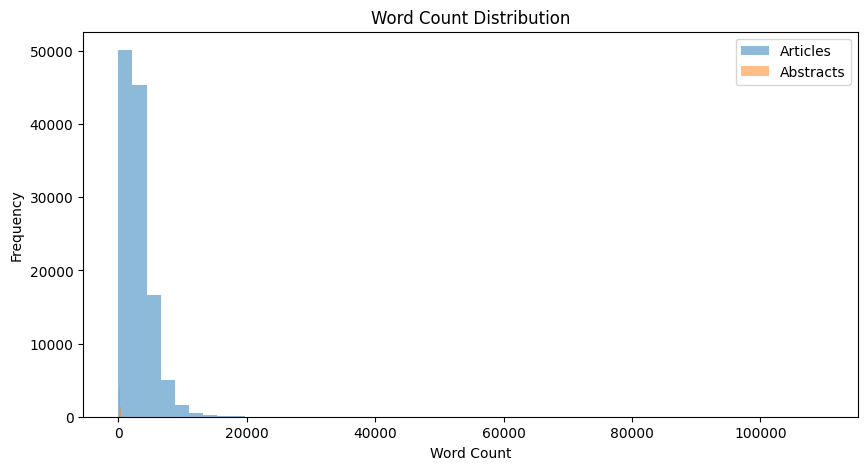

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('pubmed\train.csv')

# Display the first few rows to see the data structure
print("First few rows of the training dataset:")
display(train_df.head())

# Check for missing values in the dataset
print("Missing values in each column:")
print(train_df.isnull().sum())

# Compute word counts for articles and abstracts to understand text lengths
train_df["article_word_count"] = train_df["article"].apply(lambda x: len(str(x).split()))
train_df["abstract_word_count"] = train_df["abstract"].apply(lambda x: len(str(x).split()))

# Display descriptive statistics of the word counts
print("Article word count statistics:")
print(train_df["article_word_count"].describe())

print("Abstract word count statistics:")
print(train_df["abstract_word_count"].describe())

# Optional: Visualize the distribution of word counts for articles and abstracts
plt.figure(figsize=(10, 5))
plt.hist(train_df["article_word_count"], bins=50, alpha=0.5, label="Articles")
plt.hist(train_df["abstract_word_count"], bins=50, alpha=0.5, label="Abstracts")
plt.legend()
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [ ]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=734795146d2148f4ea27643702e9e01ecb2ac3de5e0ed28b070c7908b3e53580
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=83ac7f3718f49860723230e45316b9336cd7b41a51be71f38b7b17739b929c1d
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


DATA PREPROCESSING

In [ ]:
import pandas as pd

# -------------------------
# 1. Load CSV Files into Pandas
# -------------------------
train_df = pd.read_csv("pubmed/train.csv")
val_df = pd.read_csv("pubmed/validation.csv")
test_df = pd.read_csv("pubmed/test.csv")

print("Loaded datasets:")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

# -------------------------
# 2. Handle Missing or Empty Articles
# -------------------------
def clean_missing_articles(df, split_name):
    print(f"\nCleaning {split_name} dataset...")

    # Initial shape
    initial_shape = df.shape

    # Drop rows with NaN or empty/whitespace-only "article"
    df_cleaned = df[df["article"].notnull() & df["article"].str.strip().astype(bool)].reset_index(drop=True)

    print(f"{split_name} before cleaning: {initial_shape}")
    print(f"{split_name} after cleaning: {df_cleaned.shape}")

    return df_cleaned

train_df_clean = clean_missing_articles(train_df, "Train")
val_df_clean = clean_missing_articles(val_df, "Validation")
test_df_clean = clean_missing_articles(test_df, "Test")


Loaded datasets:
Train shape: (119924, 2)
Validation shape: (6633, 2)
Test shape: (6658, 2)

Cleaning Train dataset...
Train before cleaning: (119924, 2)
Train after cleaning: (117108, 2)

Cleaning Validation dataset...
Validation before cleaning: (6633, 2)
Validation after cleaning: (6631, 2)

Cleaning Test dataset...
Test before cleaning: (6658, 2)
Test after cleaning: (6658, 2)


In [ ]:
import pandas as pd

print(f"lenght of train dataset{len(train_df_clean)}")
# First part: Rows from 0 to 58,553 (inclusive)
train_part1 = train_df_clean.iloc[:58554].reset_index(drop=True)

# Second part: Rows from 58,554 to the end
train_part2 = train_df_clean.iloc[58554:].reset_index(drop=True)

# Save them (optional checkpointing)
train_part1.to_csv("train_part1.csv", index=False)
train_part2.to_csv("train_part2.csv", index=False)

print("Train dataset successfully divided into two parts:")
print(f"Part 1 rows: {len(train_part1)}")
print(f"Part 2 rows: {len(train_part2)}")


lenght of train dataset117108
Train dataset successfully divided into two parts:
Part 1 rows: 58554
Part 2 rows: 58554


DEFINING THE FUNCTION FOR LEXRANK SUMMARIZATION (EXTRACTIVE PART)

In [ ]:
import nltk
import pandas as pd
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from tqdm import tqdm
nltk.download("punkt_tab")

# Initialize LexRank summarizer once
summarizer = LexRankSummarizer()

def lexrank_summarize(article_text, base_sentences=5):
    try:
        word_count = len(article_text.split())

        # Dynamically set number of sentences based on article length
        if word_count > 5000:
            num_sentences = base_sentences + 5  # e.g., 10 sentences
        elif word_count > 2000:
            num_sentences = base_sentences + 2  # e.g., 7 sentences
        else:
            num_sentences = base_sentences      # e.g., 5 sentences

        # Parse the text and summarize
        parser = PlaintextParser.from_string(article_text, SumyTokenizer("english"))
        summary_sentences = summarizer(parser.document, num_sentences)

        # Join sentences into a single summary text
        summary_text = " ".join(str(sentence) for sentence in summary_sentences)

        # Fallback to original article if summary is empty
        return summary_text if summary_text.strip() != "" else article_text

    except Exception as e:
        print(f"Error summarizing article: {e}")
        return article_text

# Function to apply LexRank summarization to an entire DataFrame
def apply_lexrank_to_dataframe(df, article_column="article", summary_column="extractive_summary", base_sentences=5):
    tqdm.pandas()  # Progress bar integration
    df[summary_column] = df[article_column].progress_apply(lambda x: lexrank_summarize(x, base_sentences=base_sentences))
    return df


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


APPLYING LEXRANK SUMMARIZATION

In [ ]:
# Example usage on train_part1
train_part1_summarized = apply_lexrank_to_dataframe(train_part1)

# Save summarized part for checkpointing
train_part1_summarized.to_csv("train_part1_lexrank.csv", index=False)

print("LexRank summarization completed for train_part1 and saved!")

In [ ]:
train_part2_summarized = apply_lexrank_to_dataframe(train_part2)
train_part2_summarized.to_csv("train_part2_lexrank.csv", index=False)

print("LexRank summarization completed for train_part2 and saved!")


100%|██████████| 58554/58554 [6:03:34<00:00,  2.68it/s]


LexRank summarization completed for train_part2 and saved!


In [ ]:
train_part2_lexrank = pd.read_csv("/content/train_part2_lexrank.csv")
train_part2_lexrank.head()

,article,abstract,extractive_summary
0,febrile neutropenia ( fn ) and myelosupression...,background : febrile neutropenia ( fn ) and my...,febrile neutropenia ( fn ) and myelosupression...
1,over 50% of the world s population has been re...,the distinct brain regions could be specifical...,careful study of seizure semiology remains inv...
2,the availability of accurate quantitative data...,the datasets on gene expression are the valuab...,"besides the quantitative data , it contains co..."
3,globally defined as the application of nanotec...,born from the marriage of nanotechnology and m...,one of the many applications of nanotechnology...
4,primary cardiac tumours are a rare entity whos...,primary cardiac tumour is a rare entity as sec...,a 2-year - old male child was brought to hospi...


In [ ]:
train_part2_lexrank.head(1)['extractive_summary'].values[0]

'febrile neutropenia ( fn ) and myelosupression remain a challenging oncologic medical emergency , and dose limiting toxicity associated with chemotherapy for cancers 1 . based on our observation that patients reporting as inpatients for management of fn also frequently required intravenous electrolyte replacements , we conducted a prospective study of all patients coming to in patient care for the assessment of their electrolyte abnormalities and its possible association with , clinical presentation , length of stay , response to therapy , association with chemotherapy regimen , type of malignancy and the final outcome . all patients who were admitted with the diagnosis of chemotherapy induced febrile neutropenia were included . average length of stay in patients who received iv electrolyte replacement was 6.3 days compared to 4.9 days in those who did not ( p < 0.016 ) . we did not find any difference with regards to gender or type of malignancy ( whether solid or hematological ) wit

TRAINING T5 MODEL (ABSTRACTIVE PART)

In [ ]:
from transformers import AutoTokenizer

# Initialize the tokenizer
model_checkpoint = "t5-small"  # or t5-base / t5-large if needed
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Ensure padding is handled correctly
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from datasets import Dataset

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)

# (Optional) Inspect column names if needed
# print(train_dataset.column_names)

def preprocess_function(examples):
    # Add the T5 "summarize: " prefix to the input text
    inputs = ["summarize: " + doc for doc in examples["extractive_summary"]]
    targets = examples["abstract"]

    # Tokenize the inputs (truncated to T5's max length)
    model_inputs = tokenizer(
        inputs,
        max_length=512,
        padding="max_length",
        truncation=True
    )

    # Tokenize the labels/targets (use reasonable max length)
    labels = tokenizer(
        targets,
        max_length=209,  # Abstracts are often shorter than inputs
        padding="max_length",
        truncation=True
    )

    # Replace padding token id's in the labels with -100
    labels["input_ids"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in label_ids]
        for label_ids in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [ ]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_train_dataset.save_to_disk("t5_tokenized_train_dataset")
# Check one sample
tokenized_train_dataset[0]

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)

In [ ]:
# Load T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Using device:", device)

# Data collator for batch processing
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/",
    evaluation_strategy="no",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    optim="adafactor",
    fp16=True,
    push_to_hub=False,
    dataloader_num_workers=4,
    report_to="none"
)


In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    data_collator=data_collator
)

# Train the model
trainer.train()

GENERATE SUMMARY

In [ ]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=98f627b71e12563e0bba421d8b200e433e38ac69ecbbdf4f9043f045edcc6d6c
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1d2d62097c46247e395771290998e28a7c69c31f9027bcbefb76f91f2e6721ea
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [ ]:
import nltk
import pandas as pd
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from tqdm import tqdm
nltk.download("punkt_tab")

# Initialize LexRank summarizer once
summarizer = LexRankSummarizer()

def lexrank_summarize(article_text, base_sentences=5):
    try:
        word_count = len(article_text.split())

        # Dynamically set number of sentences based on article length
        if word_count > 5000:
            num_sentences = base_sentences + 5  # e.g., 10 sentences
        elif word_count > 2000:
            num_sentences = base_sentences + 2  # e.g., 7 sentences
        else:
            num_sentences = base_sentences      # e.g., 5 sentences

        # Parse the text and summarize
        parser = PlaintextParser.from_string(article_text, SumyTokenizer("english"))
        summary_sentences = summarizer(parser.document, num_sentences)

        # Join sentences into a single summary text
        summary_text = " ".join(str(sentence) for sentence in summary_sentences)

        # Fallback to original article if summary is empty
        return summary_text if summary_text.strip() != "" else article_text

    except Exception as e:
        print(f"Error summarizing article: {e}")
        return article_text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import pandas as pd
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Path to your checkpoint
checkpoint_dir = "epoch5-t5"

# Load model from checkpoint (ensure 'from_pretrained' points to the checkpoint path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir)

# Load tokenizer (use base model tokenizer if checkpoint lacks tokenizer files)
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def generate_summary(text, model, tokenizer, max_input_length=512, max_output_length=209):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate summary (adjust parameters for better control)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_length=max_output_length,
            min_length=50,
            length_penalty=2.0,  # Penalize longer outputs
            num_beams=4,         # Beam search for better quality
            early_stopping=True  # Stop when done token is produced
        )

    # Decode and return the summary
    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return summary


#df=pd.read_csv("pubmed/test.csv")

# Generate the summary
#summary = generate_summary(df['article'][0], model, tokenizer)
#print()
#print("Generated Summary:", summary)

article = """anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] .
although anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd [ 5 , 6 ] . yet ,
our current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression .
overall , neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance .
for example , higher depression scores have been correlated with lower scores on the mini - mental state exam ( mmse ) [ 8 , 9 ] as well as tests of memory and executive functions ( e.g. , attention ) [ 1014 ] .
likewise , apathy and anhedonia in pd patients have been associated with executive dysfunction [ 10 , 1523 ] .
however , few studies have specifically investigated the relationship between anxiety and cognition in pd .
one study showed a strong negative relationship between anxiety ( both state and trait ) and overall cognitive performance ( measured by the total of the repeatable battery for the assessment of neuropsychological status index ) within a sample of 27 pd patients .
furthermore , trait anxiety was negatively associated with each of the cognitive domains assessed by the rbans ( i.e. , immediate memory , visuospatial construction , language , attention , and delayed memory ) .
two further studies have examined whether anxiety differentially affects cognition in patients with left - sided dominant pd ( lpd ) versus right - sided dominant pd ( rpd ) ; however , their findings were inconsistent .
the first study found that working memory performance was worse in lpd patients with anxiety compared to rpd patients with anxiety , whereas the second study reported that , in lpd , apathy but not anxiety was associated with performance on nonverbally mediated executive functions and visuospatial tasks ( e.g. , tmt - b , wms - iii spatial span ) , while in rpd , anxiety but not apathy significantly correlated with performance on verbally mediated tasks ( e.g. , clock reading test and boston naming test ) .
furthermore , anxiety was significantly correlated with neuropsychological measures of attention and executive and visuospatial functions . taken together ,
it is evident that there are limited and inconsistent findings describing the relationship between anxiety and cognition in pd and more specifically how anxiety might influence particular domains of cognition such as attention and memory and executive functioning .
it is also striking that , to date , no study has examined the influence of anxiety on cognition in pd by directly comparing groups of pd patients with and without anxiety while excluding depression .
given that research on healthy young adults suggests that anxiety reduces processing capacity and impairs processing efficiency , especially in the central executive and attentional systems of working memory [ 26 , 27 ] , we hypothesized that pd patients with anxiety would show impairments in attentional set - shifting and working memory compared to pd patients without anxiety .
furthermore , since previous work , albeit limited , has focused on the influence of symptom laterality on anxiety and cognition , we also explored this relationship .
seventeen pd patients with anxiety and thirty - three pd patients without anxiety were included in this study ( see table 1 ) .
the cross - sectional data from these participants was taken from a patient database that has been compiled over the past 8 years ( since 2008 ) at the parkinson 's disease research clinic at the brain and mind centre , university of sydney .
inclusion criteria involved a diagnosis of idiopathic pd according to the united kingdom parkinson 's disease society brain bank criteria   and were confirmed by a neurologist ( sjgl ) .
patients also had to have an adequate proficiency in english and have completed a full neuropsychological assessment .
ten patients in this study ( 5 pd with anxiety ; 5 pd without anxiety ) were taking psychotropic drugs ( i.e. , benzodiazepine or selective serotonin reuptake inhibitor ) .
patients were also excluded if they had other neurological disorders , psychiatric disorders other than affective disorders ( such as anxiety ) , or if they reported a score greater than six on the depression subscale of the hospital anxiety and depression scale ( hads ) .
thus , all participants who scored within a  depressed  ( hads - d > 6 ) range were excluded from this study , in attempt to examine a refined sample of pd patients with and without anxiety in order to determine the independent effect of anxiety on cognition .
this research was approved by the human research ethics committee of the university of sydney , and written informed consent was obtained from all participants .
self - reported hads was used to assess anxiety in pd and has been previously shown to be a useful measure of clinical anxiety in pd .
a cut - off score of > 8 on the anxiety subscale of the hads ( hads - a ) was used to identify pd cases with anxiety ( pda+ ) , while a cut - off score of < 6 on the hads - a was used to identify pd cases without anxiety ( pda ) .
this criterion was more stringent than usual ( > 7 cut - off score ) , in effort to create distinct patient groups .
the neurological evaluation rated participants according to hoehn and yahr ( h&y ) stages   and assessed their motor symptoms using part iii of the revised mds task force unified parkinson 's disease rating scale ( updrs ) . in a similar way
this was determined by calculating a total left and right score from rigidity items 3035 , voluntary movement items 3643 , and tremor items 5057 from the mds - updrs part iii ( see table 1 ) .
processing speed was assessed using the trail making test , part a ( tmt - a , z - score ) .
attentional set - shifting was measured using the trail making test , part b ( tmt - b , z - score ) .
working memory was assessed using the digit span forward and backward subtest of the wechsler memory scale - iii ( raw scores ) .
language was assessed with semantic and phonemic verbal fluency via the controlled oral word associated test ( cowat animals and letters , z - score ) .
the ability to retain learned verbal memory was assessed using the logical memory subtest from the wechsler memory scale - iii ( lm - i z - score , lm - ii z - score , % lm retention z - score ) . the mini - mental state examination ( mmse )
demographic , clinical , and neuropsychological variables were compared between the two groups with the independent t - test or mann  whitney u test , depending on whether the variable met parametric assumptions .
chi - square tests were used to examine gender and symptom laterality differences between groups .
all analyses employed an alpha level of p < 0.05 and were two - tailed .
spearman correlations were performed separately in each group to examine associations between anxiety and/or depression ratings and cognitive functions .
as expected , the pda+ group reported significant greater levels of anxiety on the hads - a ( u = 0 , p < 0.001 ) and higher total score on the hads ( u = 1 , p < 0.001 ) compared to the pda group ( table 1 ) .
groups were matched in age ( t(48 ) = 1.31 , p = 0.20 ) , disease duration ( u = 259 , p = 0.66 ) , updrs - iii score ( u = 250.5 , p = 0.65 ) , h&y ( u = 245 , p = 0.43 ) , ledd ( u = 159.5 , p = 0.80 ) , and depression ( hads - d ) ( u = 190.5 , p = 0.06 ) .
additionally , all groups were matched in the distribution of gender (  = 0.098 , p = 0.75 ) and side - affected (  = 0.765 , p = 0.38 ) .
there were no group differences for tmt - a performance ( u = 256 , p = 0.62 ) ( table 2 ) ; however , the pda+ group had worse performance on the trail making test part b ( t(46 ) = 2.03 , p = 0.048 ) compared to the pda group ( figure 1 ) .
the pda+ group also demonstrated significantly worse performance on the digit span forward subtest ( t(48 ) = 2.22 , p = 0.031 ) and backward subtest ( u = 190.5 , p = 0.016 ) compared to the pda group ( figures 2(a ) and 2(b ) ) .
neither semantic verbal fluency ( t(47 ) = 0.70 , p = 0.49 ) nor phonemic verbal fluency ( t(47 ) = 0.39 , p = 0.70 ) differed between groups .
logical memory i immediate recall test ( u = 176 , p = 0.059 ) showed a trend that the pda+ group had worse new verbal learning and immediate recall abilities than the pda group . however , logical memory ii test performance ( u = 219 , p = 0.204 ) and logical memory % retention ( u = 242.5 , p = 0.434 ) did not differ between groups .
there were also no differences between groups in global cognition ( mmse ) ( u = 222.5 , p = 0.23 ) .
participants were split into lpd and rpd , and then further group differences were examined between pda+ and pda. importantly , the groups remained matched in age , disease duration , updrs - iii , dde , h&y stage , and depression but remained significantly different on self - reported anxiety .
lpda+ demonstrated worse performance on the digit span forward test ( t(19 ) = 2.29 , p = 0.033 ) compared to lpda , whereas rpda+ demonstrated worse performance on the digit span backward test ( u = 36.5 , p = 0.006 ) , lm - i immediate recall ( u = 37.5 , p = 0.008 ) , and lm - ii ( u = 45.0 , p = 0.021 ) but not lm % retention ( u = 75.5 , p = 0.39 ) compared to rpda.
this study is the first to directly compare cognition between pd patients with and without anxiety .
the findings confirmed our hypothesis that anxiety negatively influences attentional set - shifting and working memory in pd .
more specifically , we found that pd patients with anxiety were more impaired on the trail making test part b which assessed attentional set - shifting , on both digit span tests which assessed working memory and attention , and to a lesser extent on the logical memory test which assessed memory and new verbal learning compared to pd patients without anxiety . taken together ,
these findings suggest that anxiety in pd may reduce processing capacity and impair processing efficiency , especially in the central executive and attentional systems of working memory in a similar way as seen in young healthy adults [ 26 , 27 ] .
although the neurobiology of anxiety in pd remains unknown , many researchers have postulated that anxiety disorders are related to neurochemical changes that occur during the early , premotor stages of pd - related degeneration [ 37 , 38 ] such as nigrostriatal dopamine depletion , as well as cell loss within serotonergic and noradrenergic brainstem nuclei ( i.e. , raphe nuclei and locus coeruleus , resp . , which provide massive inputs to corticolimbic regions ) . over time
, chronic dysregulation of adrenocortical and catecholamine functions can lead to hippocampal damage as well as dysfunctional prefrontal neural circuitries [ 39 , 40 ] , which play a key role in memory and attention .
recent functional neuroimaging work has suggested that enhanced hippocampal activation during executive functioning and working memory tasks may represent compensatory processes for impaired frontostriatal functions in pd patients compared to controls . therefore , chronic stress from anxiety ,
for example , may disrupt compensatory processes in pd patients and explain the cognitive impairments specifically in working memory and attention seen in pd patients with anxiety .
it has also been suggested that hyperactivation within the putamen may reflect a compensatory striatal mechanism to maintain normal working memory performance in pd patients ; however , losing this compensatory activation has been shown to contribute to poor working memory performance .
anxiety in mild pd has been linked to reduced putamen dopamine uptake which becomes more extensive as the disease progresses .
this further supports the notion that anxiety may disrupt compensatory striatal mechanisms as well , providing another possible explanation for the cognitive impairments observed in pd patients with anxiety in this study .
noradrenergic and serotonergic systems should also be considered when trying to explain the mechanisms by which anxiety may influence cognition in pd . although these neurotransmitter systems are relatively understudied in pd cognition , treating the noradrenergic and serotonergic systems has shown beneficial effects on cognition in pd .
selective serotonin reuptake inhibitor , citalopram , was shown to improve response inhibition deficits in pd , while noradrenaline reuptake blocker , atomoxetine , has been recently reported to have promising effects on cognition in pd [ 45 , 46 ] .
overall , very few neuroimaging studies have been conducted in pd in order to understand the neural correlates of pd anxiety and its underlying neural pathology .
future research should focus on relating anatomical changes and neurochemical changes to neural activation in order to gain a clearer understanding on how these pathologies affect anxiety in pd . to further understand how anxiety and cognitive dysfunction are related ,
future research should focus on using advanced structural and function imaging techniques to explain both cognitive and neural breakdowns that are associated with anxiety in pd patients .
research has indicated that those with amnestic mild cognitive impairment who have more neuropsychiatric symptoms have a greater risk of developing dementia compared to those with fewer neuropsychiatric symptoms .
future studies should also examine whether treating neuropsychiatric symptoms might impact the progression of cognitive decline and improve cognitive impairments in pd patients .
previous studies have used pd symptom laterality as a window to infer asymmetrical dysfunction of neural circuits .
for example , lpd patients have greater inferred right hemisphere pathology , whereas rpd patients have greater inferred left hemisphere pathology .
thus , cognitive domains predominantly subserved by the left hemisphere ( e.g. , verbally mediated tasks of executive function and verbal memory ) might be hypothesized to be more affected in rpd than lpd ; however , this remains controversial .
it has also been suggested that since anxiety is a common feature of left hemisphere involvement [ 48 , 49 ] , cognitive domains subserved by the left hemisphere may also be more strongly related to anxiety .
results from this study showed selective verbal memory deficits in rpd patients with anxiety compared to rpd without anxiety , whereas lpd patients with anxiety had greater attentional / working memory deficits compared to lpd without anxiety .
although these results align with previous research , interpretations of these findings should be made with caution due to the small sample size in the lpd comparison specifically .
recent work has suggested that the hads questionnaire may underestimate the burden of anxiety related symptomology and therefore be a less sensitive measure of anxiety in pd [ 30 , 50 ] . in addition , our small sample size also limited the statistical power for detecting significant findings .
based on these limitations , our findings are likely conservative and underrepresent the true impact anxiety has on cognition in pd . additionally , the current study employed a very brief neuropsychological assessment including one or two tests for each cognitive domain .
future studies are encouraged to collect a more complex and comprehensive battery from a larger sample of pd participants in order to better understand the role anxiety plays on cognition in pd .
another limitation of this study was the absence of diagnostic interviews to characterize participants ' psychiatric symptoms and specify the type of anxiety disorders included in this study .
future studies should perform diagnostic interviews with participants ( e.g. , using dsm - v criteria ) rather than relying on self - reported measures to group participants , in order to better understand whether the type of anxiety disorder ( e.g. , social anxiety , phobias , panic disorders , and generalized anxiety ) influences cognitive performance differently in pd .
one advantage the hads questionnaire provided over other anxiety scales was that it assessed both anxiety and depression simultaneously and allowed us to control for coexisting depression .
although there was a trend that the pda+ group self - reported higher levels of depression than the pda group , all participants included in the study scored < 6 on the depression subscale of the hads .
controlling for depression while assessing anxiety has been identified as a key shortcoming in the majority of recent work .
considering many previous studies have investigated the influence of depression on cognition in pd without accounting for the presence of anxiety and the inconsistent findings reported to date , we recommend that future research should try to disentangle the influence of anxiety versus depression on cognitive impairments in pd . considering the growing number of clinical trials for treating depression , there are few if any for the treatment of anxiety in pd .
anxiety is a key contributor to decreased quality of life in pd and greatly requires better treatment options .
moreover , anxiety has been suggested to play a key role in freezing of gait ( fog ) , which is also related to attentional set - shifting [ 52 , 53 ] .
future research should examine the link between anxiety , set - shifting , and fog , in order to determine whether treating anxiety might be a potential therapy for improving fog ."""

extractive_summary = lexrank_summarize(article)
print("extractive_summary : ")
print(extractive_summary)
print("summary with only t5 : ")
print(generate_summary(article, model, tokenizer))
summary = generate_summary(extractive_summary, model, tokenizer)
print("Final Generated summary : ")
print(summary)


extractive_summary : 
the first study found that working memory performance was worse in lpd patients with anxiety compared to rpd patients with anxiety , whereas the second study reported that , in lpd , apathy but not anxiety was associated with performance on nonverbally mediated executive functions and visuospatial tasks ( e.g. , tmt - b , wms - iii spatial span ) , while in rpd , anxiety but not apathy significantly correlated with performance on verbally mediated tasks ( e.g. , clock reading test and boston naming test ) . more specifically , we found that pd patients with anxiety were more impaired on the trail making test part b which assessed attentional set - shifting , on both digit span tests which assessed working memory and attention , and to a lesser extent on the logical memory test which assessed memory and new verbal learning compared to pd patients without anxiety . therefore , chronic stress from anxiety , for example , may disrupt compensatory processes in pd patie

POST-PROCESSING

In [ ]:
!pip install language_tool_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

corrected_text = tool.correct(summary)
print(corrected_text)


INFO:language_tool_python.download_lt:Unzipping /tmp/tmprhv7d18y.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.5.zip to /root/.cache/language_tool_python.


Background : chronic stress from anxiety may disrupt compensatory processes in pd.methods:a cross-sectional study was carried out to assess the influence of anxiety versus depression on cognitive impairments in pd.results:in this study, pd patients with anxiety were more impaired on the trail making test part b which assessed attentional set - shifting, on both digit span tests which assessed working memory and attention, and to a lesser extent on the logical memory test which assessed cognitive impairments in pd patients with anxiety compared to RPD without anxiety, while the PDA+ group self - reported greater attentional / working memory deficits compared to RPD without anxiety.results:in this study, pd patients with anxiety were more impaired on the trail making test part b which assessed attentional set - shifting, on both digit


In [ ]:
import re
import language_tool_python

tool = language_tool_python.LanguageTool('en-US')

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text, flags=re.IGNORECASE)
    sentences = text.split('. ')
    unique_sentences = list(dict.fromkeys(sentences))
    cleaned_text = '. '.join(unique_sentences)
    return cleaned_text.strip()

def grammar_check(text):
    matches = tool.check(text)
    corrected_text = language_tool_python.utils.correct(text, matches)
    return corrected_text

def structure_summary_regex(text):
    # Clean text first
    text = text.lower()

    # Define patterns for sections
    patterns = {
        "background": r"(background\s*[:\-]?\s*)(.*?)(methods\s*[:\-]?)",
        "methods": r"(methods\s*[:\-]?\s*)(.*?)(results\s*[:\-]?)",
        "results": r"(results\s*[:\-]?\s*)(.*?)(conclusion\s*[:\-]?|$)",
        "conclusion": r"(conclusion\s*[:\-]?\s*)(.*)",
    }

    sections = {}

    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.DOTALL)
        if match:
            # Group 2 is the actual content
            sections[key.capitalize()] = match.group(2).strip()

    return sections

def post_process_summary(raw_summary):
    print("🔧 Running Improved Post-Processing Pipeline...")

    # Step 1: Clean raw text
    cleaned_text = clean_text(raw_summary)
    print("✅ Cleaned text")

    # Step 2: Grammar and style correction
    corrected_text = grammar_check(cleaned_text)
    print("✅ Grammar checked")

    # Step 3: Structured summary using regex
    sections = structure_summary_regex(corrected_text)

    if not sections:
        print("⚠️ Could not structure sections, returning corrected text")
        return corrected_text

    structured_summary = ""
    for section, content in sections.items():
        structured_summary += f"{section}:\n{content}\n\n"

    print("✅ Structuring complete")

    return structured_summary.strip()

# Example input (same as before)
raw_summary = """
background : chronic stress from anxiety may disrupt compensatory processes in pd.objectives:the aim of this study was to investigate the influence of anxiety versus depression on cognitive impairments in pd.materials and methods : in this cross - sectional study, we compared pd patients with anxiety with anxiety compared to rpd without anxiety.results:the pda+ group self - reported higher levels of depression than the pda+ group without anxiety, whereas lpd patients with anxiety had greater attentional / working memory deficits compared to rpd without anxiety.results:the pda+ group self - reported greater attentional / working memory deficits in pd patients with anxiety compared to rpd without anxiety, while in rpd without anxiety, anxiety was associated with performance on nonverbally mediated
"""

# Run the improved pipeline
final_summary = post_process_summary(raw_summary)

print("\n✨ Final Post-Processed Summary ✨")
print(final_summary)


🔧 Running Improved Post-Processing Pipeline...
✅ Cleaned text
✅ Grammar checked
✅ Structuring complete

✨ Final Post-Processed Summary ✨
Background:
chronic stress from anxiety may disrupt compensatory processes in pd.objectives:the aim of this study was to investigate the influence of anxiety versus depression on cognitive impairments in pd. materials and

Methods:
in this cross-sectional study, we compared pd patients with anxiety compared to rpd without anxiety.

Results:
the pda+ group self - reported higher levels of depression than the pda+ group without anxiety, whereas lpd patients with anxiety had greater attentional / working memory deficits compared to rpd without anxiety.results:the pda+ group self - reported greater attentional / working memory deficits in pd patients with anxiety compared to rpd without anxiety, while in rpd without anxiety, anxiety was associated with performance on nonverbally mediated
